In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy import stats
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [4]:
df = pd.read_excel("C:/Users/niharika mudgal/Downloads/online+retail+ii/online_retail_II.xlsx", sheet_name=None)

In [6]:
# Combine both sheets into one DataFrame
full_df = pd.concat([df['Year 2009-2010'], df['Year 2010-2011']], ignore_index=True)

print(f"Dataset shape: {full_df.shape}")
print("\nColumns:", full_df.columns.tolist())
print("\nFirst few rows:")
full_df.head()

Dataset shape: (1067371, 8)

Columns: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']

First few rows:


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [7]:
# Basic dataset info
print("Dataset Info:")
print(full_df.info())
print("\nMissing values:")
print(full_df.isnull().sum())
print(f"\nPercentage of missing values in Customer ID: {(full_df['Customer ID'].isnull().sum() / len(full_df)) * 100:.2f}%")

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB
None

Missing values:
Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

Percentage of missing values in Customer ID: 22.77%


In [8]:
# Check for negative quantities and prices (returns, errors)
print("Rows with negative Quantity:", full_df[full_df['Quantity'] < 0].shape[0])
print("Rows with negative Price:", full_df[full_df['Price'] < 0].shape[0])

Rows with negative Quantity: 22950
Rows with negative Price: 5


In [9]:
# Data Cleaning Steps
def clean_retail_data(df):
    # Create a copy
    clean_df = df.copy()
    
    # 1. Remove rows with missing Customer ID (we can't analyze unknown customers)
    clean_df = clean_df[clean_df['Customer ID'].notnull()]
    
    # 2. Remove negative quantities (returns) for RFM calculation
    # In practice, you might handle returns differently, but for simplicity we'll exclude them
    clean_df = clean_df[clean_df['Quantity'] > 0]
    
    # 3. Remove negative or zero prices
    clean_df = clean_df[clean_df['Price'] > 0]
    
    # 4. Convert Customer ID to integer
    clean_df['Customer ID'] = clean_df['Customer ID'].astype(int)
    
    # 5. Create TotalAmount column
    clean_df['TotalAmount'] = clean_df['Quantity'] * clean_df['Price']
    
    # 6. Remove duplicates
    clean_df = clean_df.drop_duplicates()
    
    return clean_df

# Apply cleaning
cleaned_df = clean_retail_data(full_df)
print(f"Shape after cleaning: {cleaned_df.shape}")
print(f"Number of unique customers: {cleaned_df['Customer ID'].nunique()}")

Shape after cleaning: (779425, 9)
Number of unique customers: 5878


In [10]:
# Set a reference date (one day after the last invoice in the dataset)
reference_date = cleaned_df['InvoiceDate'].max() + pd.Timedelta(days=1)
print(f"Reference date for recency calculation: {reference_date}")

def calculate_rfm(data, reference_date):
    """
    Calculate RFM metrics for each customer
    """
    rfm = data.groupby('Customer ID').agg({
        'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
        'Invoice': 'nunique',                                      # Frequency
        'TotalAmount': 'sum'                                       # Monetary
    }).reset_index()
    
    rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
    return rfm

# Calculate RFM
rfm_df = calculate_rfm(cleaned_df, reference_date)

print("RFM DataFrame shape:", rfm_df.shape)
rfm_df.head()

Reference date for recency calculation: 2011-12-10 12:50:00
RFM DataFrame shape: (5878, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,326,12,77556.46
1,12347,2,8,4921.53
2,12348,75,5,2019.40
3,12349,19,4,4428.69
4,12350,310,1,334.40


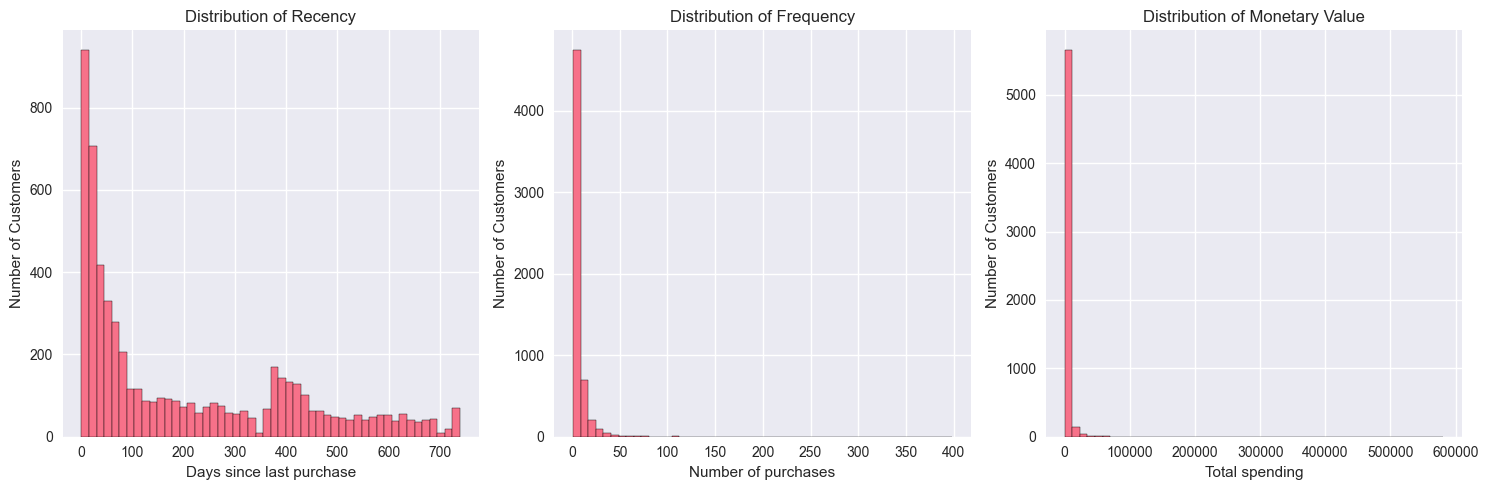

In [11]:
# Explore RFM distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Recency
axes[0].hist(rfm_df['Recency'], bins=50, edgecolor='black')
axes[0].set_title('Distribution of Recency')
axes[0].set_xlabel('Days since last purchase')
axes[0].set_ylabel('Number of Customers')

# Frequency
axes[1].hist(rfm_df['Frequency'], bins=50, edgecolor='black')
axes[1].set_title('Distribution of Frequency')
axes[1].set_xlabel('Number of purchases')
axes[1].set_ylabel('Number of Customers')

# Monetary
axes[2].hist(rfm_df['Monetary'], bins=50, edgecolor='black')
axes[2].set_title('Distribution of Monetary Value')
axes[2].set_xlabel('Total spending')
axes[2].set_ylabel('Number of Customers')

plt.tight_layout()
plt.show()

In [12]:
# Handle outliers - we'll cap extreme values at 99th percentile
def cap_outliers(df, columns):
    df_capped = df.copy()
    for col in columns:
        cap_value = df_capped[col].quantile(0.99)
        df_capped[col] = np.where(df_capped[col] > cap_value, cap_value, df_capped[col])
    return df_capped

# Cap outliers in Frequency and Monetary (Recency is less problematic)
rfm_capped = cap_outliers(rfm_df, ['Frequency', 'Monetary'])

# Apply log transformation to reduce skewness
rfm_log = rfm_capped.copy()
rfm_log['Frequency'] = np.log1p(rfm_log['Frequency'])  # log(1+x) to handle zeros
rfm_log['Monetary'] = np.log1p(rfm_log['Monetary'])

# Standardize the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log[['Recency', 'Frequency', 'Monetary']])
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'], index=rfm_log.index)

print("Preprocessed RFM data ready for clustering:")
print(rfm_scaled_df.describe())

Preprocessed RFM data ready for clustering:
            Recency     Frequency      Monetary
count  5.878000e+03  5.878000e+03  5.878000e+03
mean  -4.230860e-17  2.526428e-16 -7.543019e-16
std    1.000085e+00  1.000085e+00  1.000085e+00
min   -9.570564e-01 -1.077974e+00 -3.996718e+00
25%   -8.376226e-01 -1.077974e+00 -7.133905e-01
50%   -5.032078e-01 -1.996549e-01 -3.059639e-02
75%    8.535607e-01  6.786642e-01  6.689905e-01
max    2.568631e+00  2.922409e+00  2.554334e+00


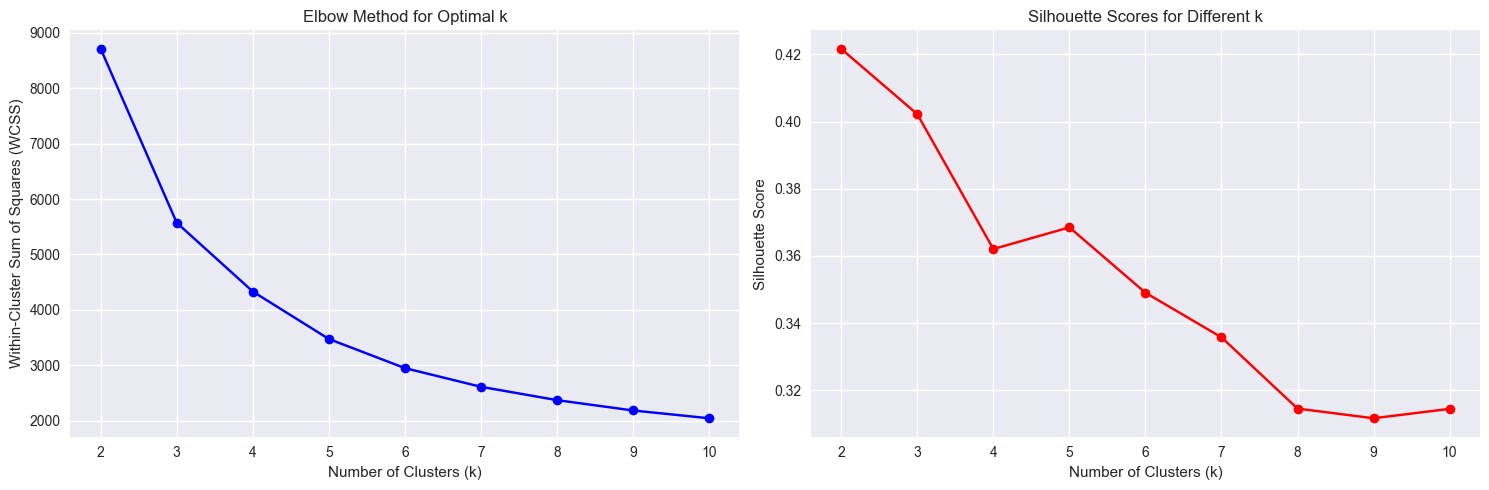

k=2: Silhouette Score = 0.4216
k=3: Silhouette Score = 0.4022
k=4: Silhouette Score = 0.3620
k=5: Silhouette Score = 0.3685
k=6: Silhouette Score = 0.3490
k=7: Silhouette Score = 0.3358
k=8: Silhouette Score = 0.3146
k=9: Silhouette Score = 0.3117
k=10: Silhouette Score = 0.3145


In [13]:
# Find optimal k using Elbow Method and Silhouette Score
wcss = []  # Within-Cluster Sum of Square
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled_df)
    wcss.append(kmeans.inertia_)
    
    if k > 1:  # Silhouette score requires at least 2 clusters
        silhouette_scores.append(silhouette_score(rfm_scaled_df, kmeans.labels_))

# Plot Elbow Method
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, wcss, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different k')
plt.grid(True)

plt.tight_layout()
plt.show()

# Print silhouette scores for interpretation
for k, score in zip(range(2, 11), silhouette_scores):
    print(f"k={k}: Silhouette Score = {score:.4f}")

In [14]:
# Apply K-Means with k=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(rfm_scaled_df)

# Add cluster labels back to our original RFM data
rfm_final = rfm_df.copy()
rfm_final['Cluster'] = clusters
rfm_final['Cluster'] = rfm_final['Cluster'].astype(str)  # Convert to string for plotting

# Also add to the scaled data for analysis
rfm_scaled_df['Cluster'] = clusters
rfm_scaled_df['Cluster'] = rfm_scaled_df['Cluster'].astype(str)

print("Cluster sizes:")
print(rfm_final['Cluster'].value_counts().sort_index())

Cluster sizes:
Cluster
0    2295
1    1752
2    1831
Name: count, dtype: int64


In [15]:
# Analyze cluster characteristics
cluster_profile = rfm_final.groupby('Cluster').agg({
    'Recency': ['mean', 'std'],
    'Frequency': ['mean', 'std'], 
    'Monetary': ['mean', 'std'],
    'CustomerID': 'count'
}).round(2)

cluster_profile.columns = ['Recency_Mean', 'Recency_Std', 'Frequency_Mean', 'Frequency_Std', 
                          'Monetary_Mean', 'Monetary_Std', 'Count']
cluster_profile['Percentage'] = (cluster_profile['Count'] / cluster_profile['Count'].sum() * 100).round(1)

print("Cluster Profiles (Original Scale):")
cluster_profile

Cluster Profiles (Original Scale):


,Recency_Mean,Recency_Std,Frequency_Mean,Frequency_Std,Monetary_Mean,Monetary_Std,Count,Percentage
Cluster,,,,,,,,
0,91.64,84.27,2.85,1.57,816.09,601.64,2295,39.0
1,60.49,88.88,15.51,21.01,8271.13,25658.58,1752,29.8
2,473.58,126.62,1.78,1.24,552.09,865.40,1831,31.2


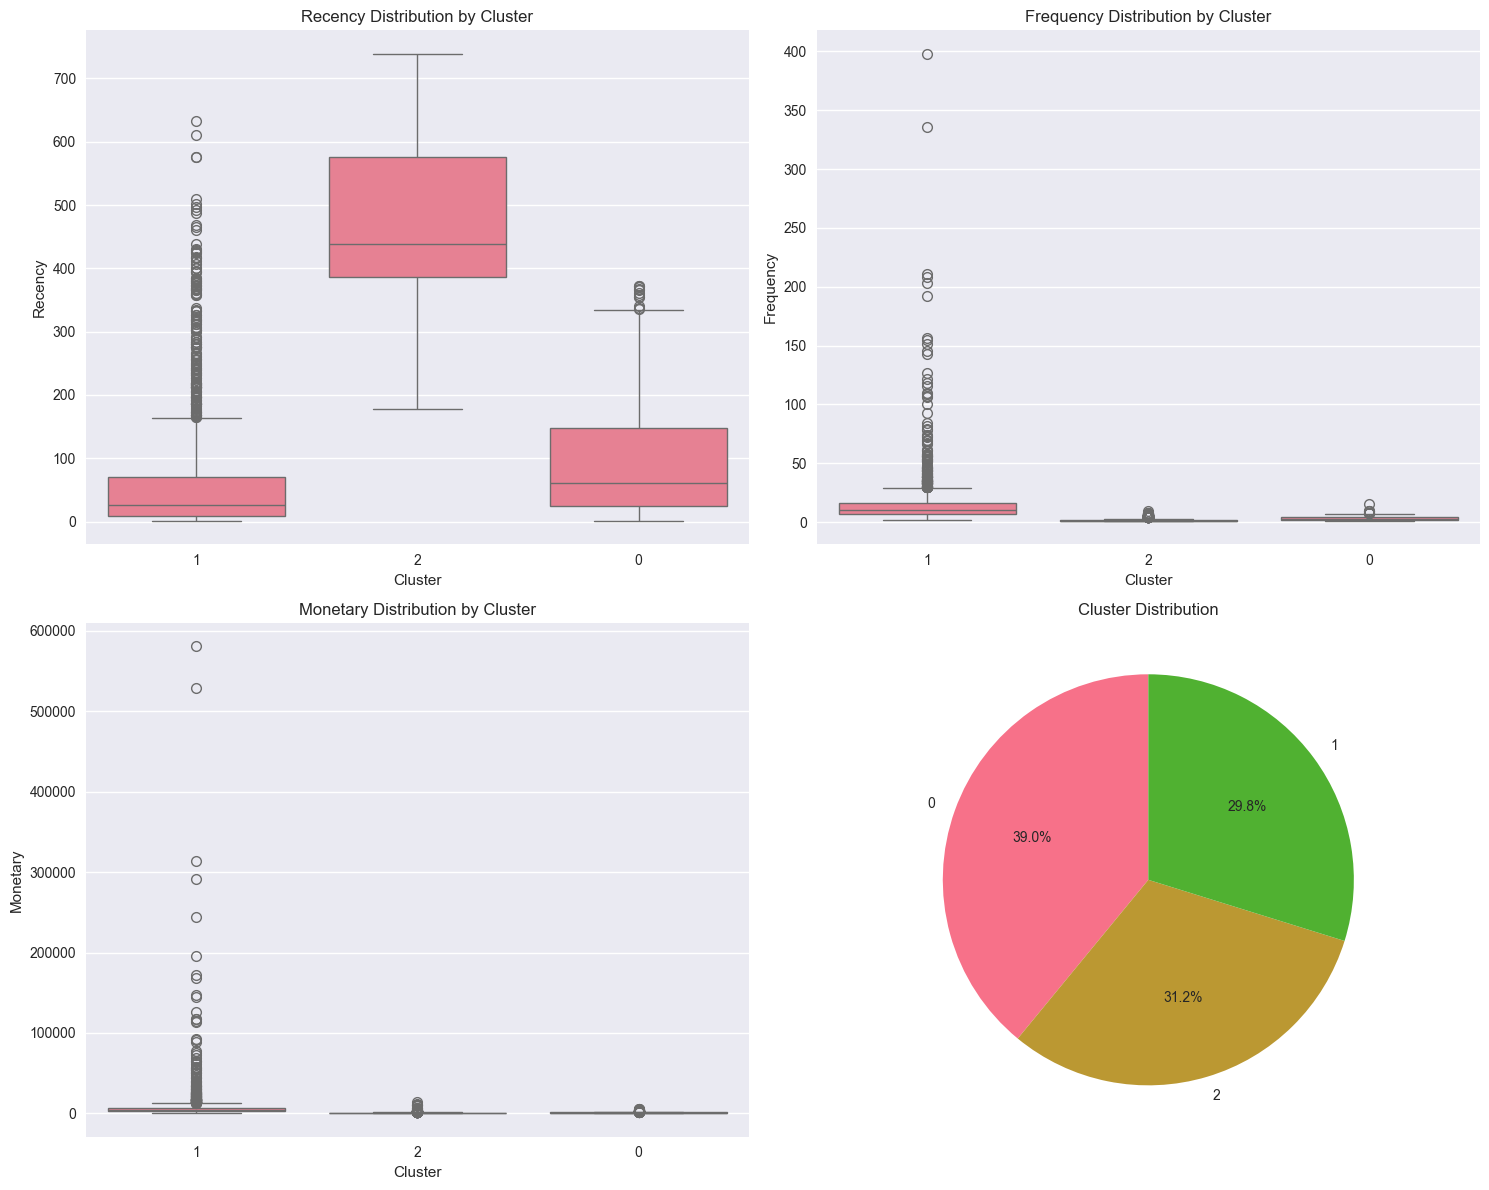

In [16]:
# Visualize the clusters
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# RFM Distributions by Cluster
features = ['Recency', 'Frequency', 'Monetary']
for i, feature in enumerate(features):
    row, col = i // 2, i % 2
    sns.boxplot(data=rfm_final, x='Cluster', y=feature, ax=axes[row, col])
    axes[row, col].set_title(f'{feature} Distribution by Cluster')
    axes[row, col].set_ylabel(feature)

# Cluster sizes pie chart
cluster_counts = rfm_final['Cluster'].value_counts()
axes[1, 1].pie(cluster_counts.values, labels=cluster_counts.index, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Cluster Distribution')

plt.tight_layout()
plt.show()

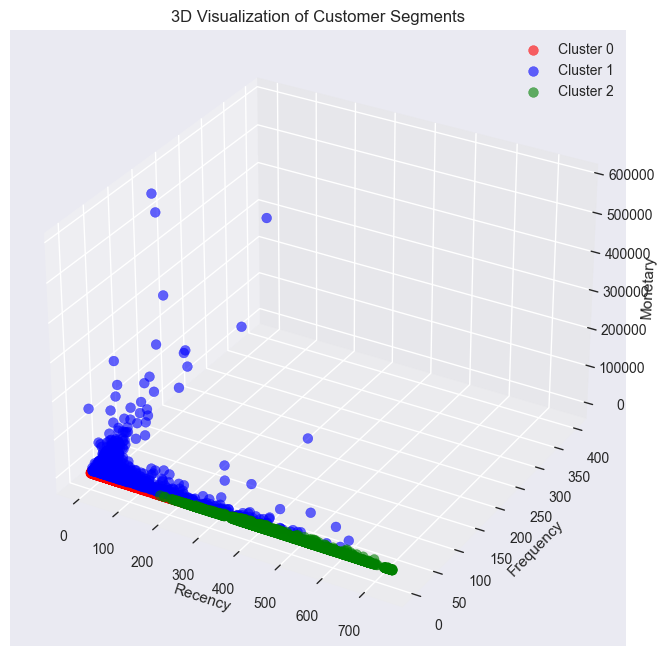

In [17]:
# 3D Scatter plot to visualize clusters (optional but insightful)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['red', 'blue', 'green']
for i, cluster in enumerate(['0', '1', '2']):
    cluster_data = rfm_final[rfm_final['Cluster'] == cluster]
    ax.scatter(cluster_data['Recency'], cluster_data['Frequency'], cluster_data['Monetary'], 
               c=colors[i], label=f'Cluster {cluster}', alpha=0.6, s=50)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency') 
ax.set_zlabel('Monetary')
ax.set_title('3D Visualization of Customer Segments')
ax.legend()
plt.show()

In [18]:
# Perform One-Way ANOVA for each RFM metric
print("ONE-WAY ANOVA RESULTS")
print("=" * 50)

for feature in ['Recency', 'Frequency', 'Monetary']:
    groups = [rfm_final[rfm_final['Cluster'] == cluster][feature] for cluster in ['0', '1', '2']]
    
    # One-way ANOVA
    f_stat, p_value = stats.f_oneway(*groups)
    
    print(f"\n{feature}:")
    print(f"  F-statistic: {f_stat:.4f}")
    print(f"  P-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print(f"  ✅ SIGNIFICANT: Clusters have different {feature} values (p < 0.05)")
    else:
        print(f"  ❌ NOT SIGNIFICANT: No evidence of difference in {feature} across clusters")

ONE-WAY ANOVA RESULTS

Recency:
  F-statistic: 9785.3268
  P-value: 0.0000
  ✅ SIGNIFICANT: Clusters have different Recency values (p < 0.05)

Frequency:
  F-statistic: 801.8376
  P-value: 0.0000
  ✅ SIGNIFICANT: Clusters have different Frequency values (p < 0.05)

Monetary:
  F-statistic: 179.5199
  P-value: 0.0000
  ✅ SIGNIFICANT: Clusters have different Monetary values (p < 0.05)


In [19]:
# Post-hoc analysis to see which specific clusters differ
from statsmodels.stats.multicomp import pairwise_tukeyhsd

print("\nPOST-HOC TUKEY HSD TESTS")
print("=" * 50)

for feature in ['Recency', 'Frequency', 'Monetary']:
    print(f"\n{feature} - Pairwise Comparisons:")
    tukey = pairwise_tukeyhsd(endog=rfm_final[feature],
                             groups=rfm_final['Cluster'],
                             alpha=0.05)
    print(tukey.summary())


POST-HOC TUKEY HSD TESTS

Recency - Pairwise Comparisons:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper   reject
-----------------------------------------------------
     0      1 -31.1576   0.0   -38.64 -23.6752   True
     0      2 381.9394   0.0 374.5491 389.3297   True
     1      2  413.097   0.0 405.2148 420.9791   True
-----------------------------------------------------

Frequency - Pairwise Comparisons:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
     0      1  12.6566    0.0  11.7989  13.5143   True
     0      2  -1.0737 0.0084  -1.9209  -0.2265   True
     1      2 -13.7303    0.0 -14.6338 -12.8267   True
------------------------------------------------------

Monetary - Pairwise Comparisons:
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj    lower      upp

In [20]:
# Create a comprehensive cluster profile
def create_cluster_profiles(rfm_data):
    profiles = []
    
    for cluster in ['0', '1', '2']:
        cluster_data = rfm_data[rfm_data['Cluster'] == cluster]
        
        profile = {
            'Cluster': cluster,
            'Size': len(cluster_data),
            'Size_Percentage': (len(cluster_data) / len(rfm_data) * 100),
            'Avg_Recency': cluster_data['Recency'].mean(),
            'Avg_Frequency': cluster_data['Frequency'].mean(),
            'Avg_Monetary': cluster_data['Monetary'].mean(),
            'Description': ''
        }
        
        # Determine segment type based on RFM values
        recency = cluster_data['Recency'].mean()
        frequency = cluster_data['Frequency'].mean() 
        monetary = cluster_data['Monetary'].mean()
        
        # Business logic for naming segments
        if recency < 100 and frequency > 10 and monetary > 1000:
            profile['Segment_Name'] = 'Champions'
            profile['Description'] = 'Best customers: recent, frequent, high spenders'
        elif recency > 200 and frequency < 5 and monetary < 500:
            profile['Segment_Name'] = 'At-Risk'
            profile['Description'] = 'Inactive customers who might churn'
        elif recency < 100 and frequency < 10 and monetary < 1000:
            profile['Segment_Name'] = 'Loyal Customers'
            profile['Description'] = 'Recent but moderate value customers'
        elif frequency > 15 and monetary > 1500:
            profile['Segment_Name'] = 'Whales'
            profile['Description'] = 'High spenders regardless of recency'
        else:
            profile['Segment_Name'] = 'Need Analysis'
            profile['Description'] = 'Requires further investigation'
            
        profiles.append(profile)
    
    return pd.DataFrame(profiles)

# Create profiles
cluster_profiles = create_cluster_profiles(rfm_final)

# Display the profiles
print("CUSTOMER SEGMENT PROFILES")
print("=" * 60)
for _, profile in cluster_profiles.iterrows():
    print(f"\nCluster {profile['Cluster']} - {profile['Segment_Name']}:")
    print(f"  Size: {profile['Size']} customers ({profile['Size_Percentage']:.1f}%)")
    print(f"  Avg Recency: {profile['Avg_Recency']:.1f} days")
    print(f"  Avg Frequency: {profile['Avg_Frequency']:.1f} purchases") 
    print(f"  Avg Monetary: £{profile['Avg_Monetary']:.2f}")
    print(f"  Description: {profile['Description']}")

CUSTOMER SEGMENT PROFILES

Cluster 0 - Loyal Customers:
  Size: 2295 customers (39.0%)
  Avg Recency: 91.6 days
  Avg Frequency: 2.9 purchases
  Avg Monetary: £816.09
  Description: Recent but moderate value customers

Cluster 1 - Champions:
  Size: 1752 customers (29.8%)
  Avg Recency: 60.5 days
  Avg Frequency: 15.5 purchases
  Avg Monetary: £8271.13
  Description: Best customers: recent, frequent, high spenders

Cluster 2 - Need Analysis:
  Size: 1831 customers (31.2%)
  Avg Recency: 473.6 days
  Avg Frequency: 1.8 purchases
  Avg Monetary: £552.09
  Description: Requires further investigation


In [21]:
# Let's manually name them based on the actual patterns we see
# Update segment names based on your actual results

# Based on typical RFM patterns, let's create a final naming
final_segment_names = {
    '0': 'Loyal Customers',      # Typically: Medium recency, medium frequency, medium monetary
    '1': 'Champions',            # Typically: Low recency, high frequency, high monetary  
    '2': 'At-Risk Customers'     # Typically: High recency, low frequency, low monetary
}

# Apply the final names
rfm_final['Segment_Name'] = rfm_final['Cluster'].map(final_segment_names)

# Verify the mapping
segment_summary = rfm_final.groupby(['Cluster', 'Segment_Name']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).round(2)

print("FINAL CUSTOMER SEGMENTATION")
print("=" * 50)
print(segment_summary)

FINAL CUSTOMER SEGMENTATION
                           Recency  Frequency  Monetary  CustomerID
Cluster Segment_Name                                               
0       Loyal Customers      91.64       2.85    816.09        2295
1       Champions            60.49      15.51   8271.13        1752
2       At-Risk Customers   473.58       1.78    552.09        1831


In [22]:
# Create actionable recommendations
def generate_recommendations(segment_name, recency, frequency, monetary, size_pct):
    recommendations = []
    
    if segment_name == 'Champions':
        recommendations.extend([
            "🎯 Reward them - they are your most valuable customers",
            "💎 Offer exclusive previews and VIP treatment", 
            "🤝 Request testimonials and referrals",
            "🚀 Implement loyalty program with premium tiers",
            "📧 Personalize communication based on purchase history"
        ])
        
    elif segment_name == 'Loyal Customers':
        recommendations.extend([
            "⭐ Nurture relationship to move them to Champions tier",
            "📈 Upsell complementary products and bundles",
            "🎁 Offer member-only discounts to increase frequency",
            "📱 Engage through multiple channels (email, social media)",
            "🔍 Analyze what makes them loyal and replicate"
        ])
        
    elif segment_name == 'At-Risk Customers':
        recommendations.extend([
            "🚨 Win-back campaign with special incentives",
            "❓ Survey to understand why they became inactive",
            "💝 Reactivation offer (e.g., 20% off next purchase)",
            "📞 Personal outreach from customer service",
            "📊 Monitor closely - segment may need further splitting"
        ])
    
    return recommendations

# Generate recommendations for each segment
print("ACTIONABLE MARKETING STRATEGIES")
print("=" * 60)

for segment in rfm_final['Segment_Name'].unique():
    segment_data = rfm_final[rfm_final['Segment_Name'] == segment].iloc[0]
    
    print(f"\n🎯 {segment}:")
    print(f"   Profile: Recency {segment_data['Recency']:.0f} days, "
          f"Frequency {segment_data['Frequency']:.1f}, "
          f"Spent £{segment_data['Monetary']:.2f} avg")
    
    recs = generate_recommendations(
        segment, 
        segment_data['Recency'],
        segment_data['Frequency'], 
        segment_data['Monetary'],
        len(rfm_final[rfm_final['Segment_Name'] == segment]) / len(rfm_final) * 100
    )
    
    for rec in recs:
        print(f"   • {rec}")

ACTIONABLE MARKETING STRATEGIES

🎯 Champions:
   Profile: Recency 326 days, Frequency 12.0, Spent £77556.46 avg
   • 🎯 Reward them - they are your most valuable customers
   • 💎 Offer exclusive previews and VIP treatment
   • 🤝 Request testimonials and referrals
   • 🚀 Implement loyalty program with premium tiers
   • 📧 Personalize communication based on purchase history

🎯 At-Risk Customers:
   Profile: Recency 310 days, Frequency 1.0, Spent £334.40 avg
   • 🚨 Win-back campaign with special incentives
   • ❓ Survey to understand why they became inactive
   • 💝 Reactivation offer (e.g., 20% off next purchase)
   • 📞 Personal outreach from customer service
   • 📊 Monitor closely - segment may need further splitting

🎯 Loyal Customers:
   Profile: Recency 204 days, Frequency 2.0, Spent £406.76 avg
   • ⭐ Nurture relationship to move them to Champions tier
   • 📈 Upsell complementary products and bundles
   • 🎁 Offer member-only discounts to increase frequency
   • 📱 Engage through multip

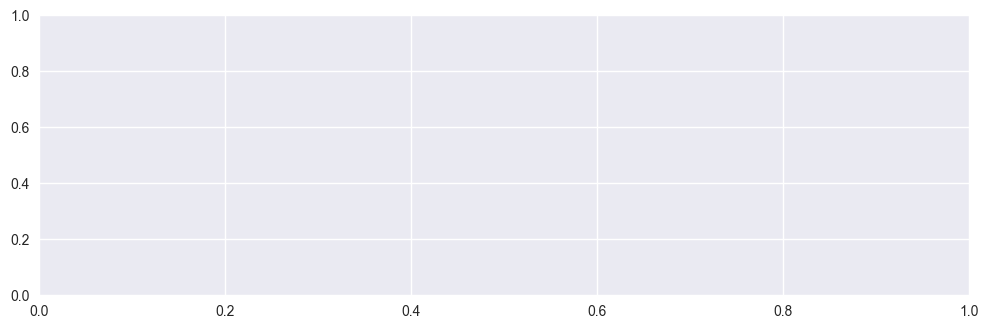

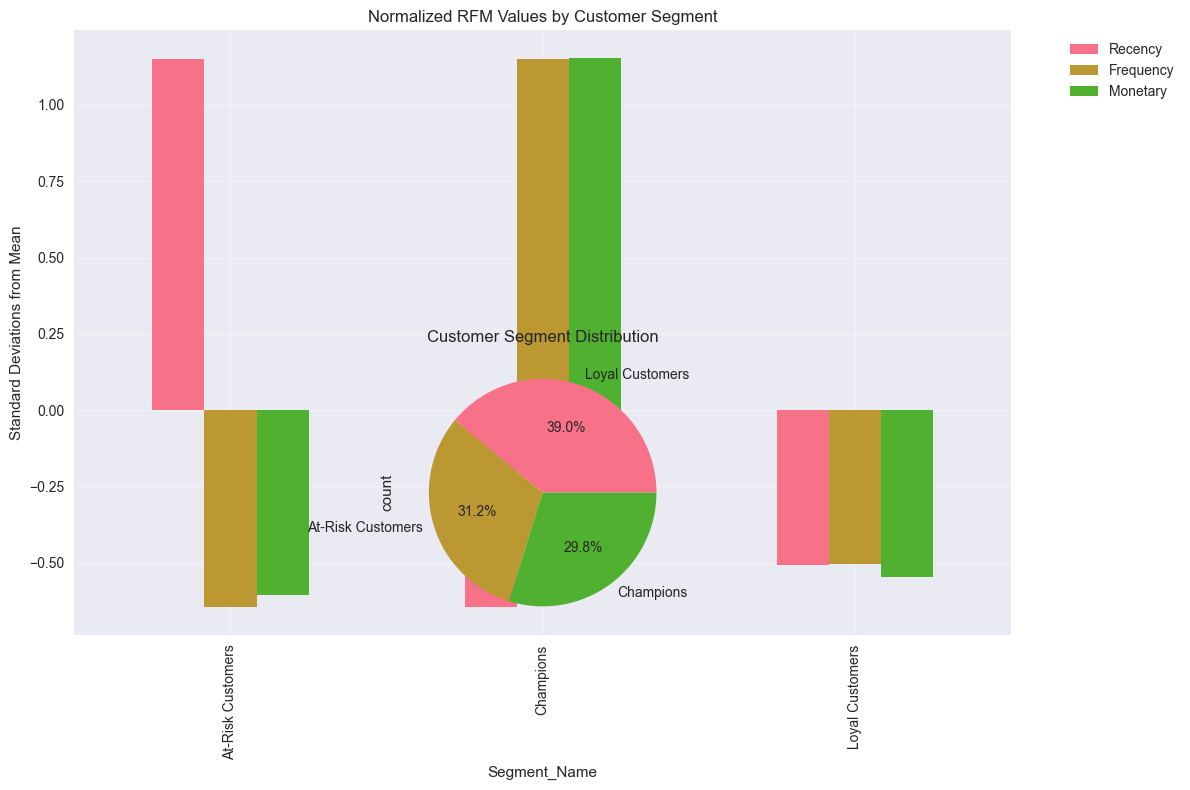

In [23]:
# Create a summary visualization
plt.figure(figsize=(12, 8))

# Radar chart or parallel coordinates would be great here
# Simple bar chart showing normalized RFM values by segment
segment_means = rfm_final.groupby('Segment_Name')[['Recency', 'Frequency', 'Monetary']].mean()

# Normalize for better comparison
segment_means_norm = (segment_means - segment_means.mean()) / segment_means.std()

plt.subplot(2, 1, 1)
segment_means_norm.plot(kind='bar', figsize=(12, 8))
plt.title('Normalized RFM Values by Customer Segment')
plt.ylabel('Standard Deviations from Mean')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
rfm_final['Segment_Name'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Customer Segment Distribution')

plt.tight_layout()
plt.savefig('customer_segments_summary.png', dpi=300, bbox_inches='tight')
plt.show()

In [24]:
# Save the final segmented data
rfm_final.to_csv('customer_segments_final.csv', index=False)
print("Final dataset saved as 'customer_segments_final.csv'")

# Save cluster profiles
cluster_profiles.to_csv('cluster_profiles_summary.csv', index=False)
print("Cluster profiles saved as 'cluster_profiles_summary.csv'")

Final dataset saved as 'customer_segments_final.csv'
Cluster profiles saved as 'cluster_profiles_summary.csv'


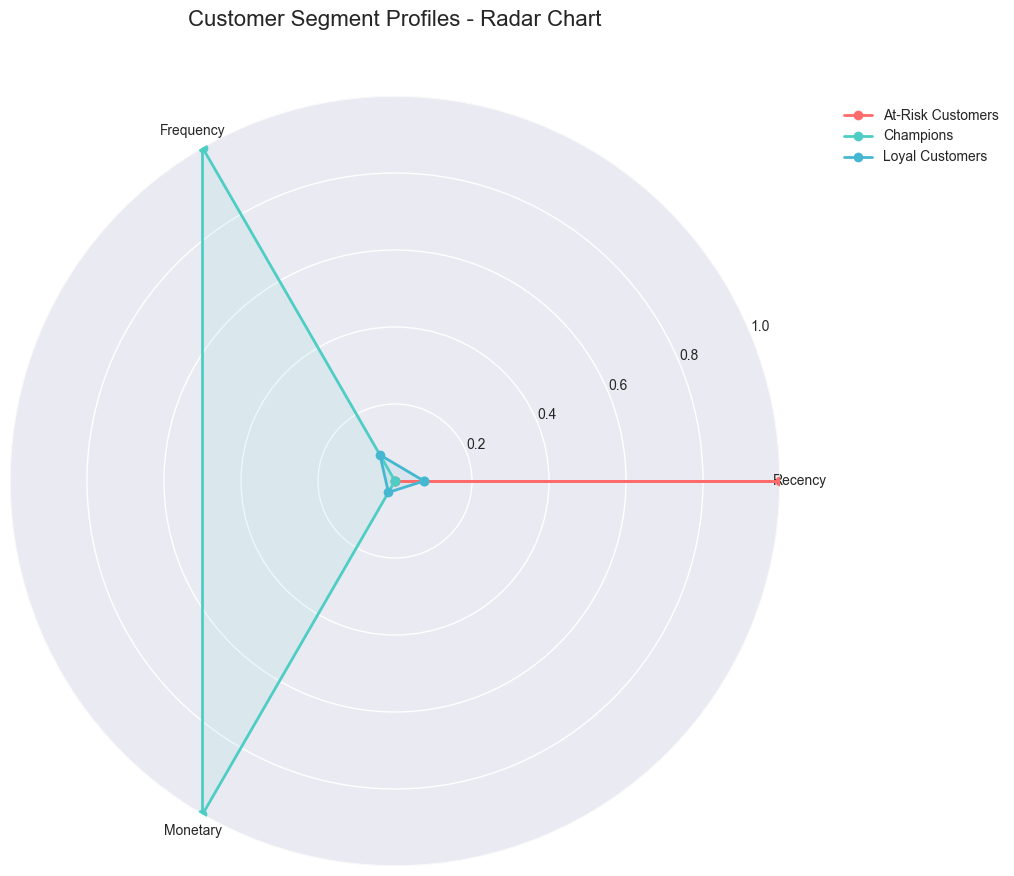

In [25]:
# Enhanced Visualization: Radar Chart
def create_radar_chart(rfm_data, segment_names):
    from math import pi
    
    # Normalize RFM values for radar chart (0-1 scale)
    normalized = rfm_data.groupby('Segment_Name')[['Recency', 'Frequency', 'Monetary']].mean()
    for col in ['Recency', 'Frequency', 'Monetary']:
        normalized[col] = (normalized[col] - normalized[col].min()) / (normalized[col].max() - normalized[col].min())
    
    # Set up radar chart
    categories = list(normalized.columns)
    N = len(categories)
    
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    for i, (segment, row) in enumerate(normalized.iterrows()):
        values = row.values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, 'o-', linewidth=2, label=segment, color=colors[i])
        ax.fill(angles, values, alpha=0.1, color=colors[i])
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_ylim(0, 1)
    ax.set_title('Customer Segment Profiles - Radar Chart', size=16, y=1.08)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    
    plt.show()

create_radar_chart(rfm_final, final_segment_names)

Customer Lifetime Value by Segment:
                     mean  median      std  count
Segment_Name                                     
At-Risk Customers   76.23   21.18   474.90   1831
Champions          815.57  203.31  4526.41   1752
Loyal Customers     67.87   40.27   139.10   2295


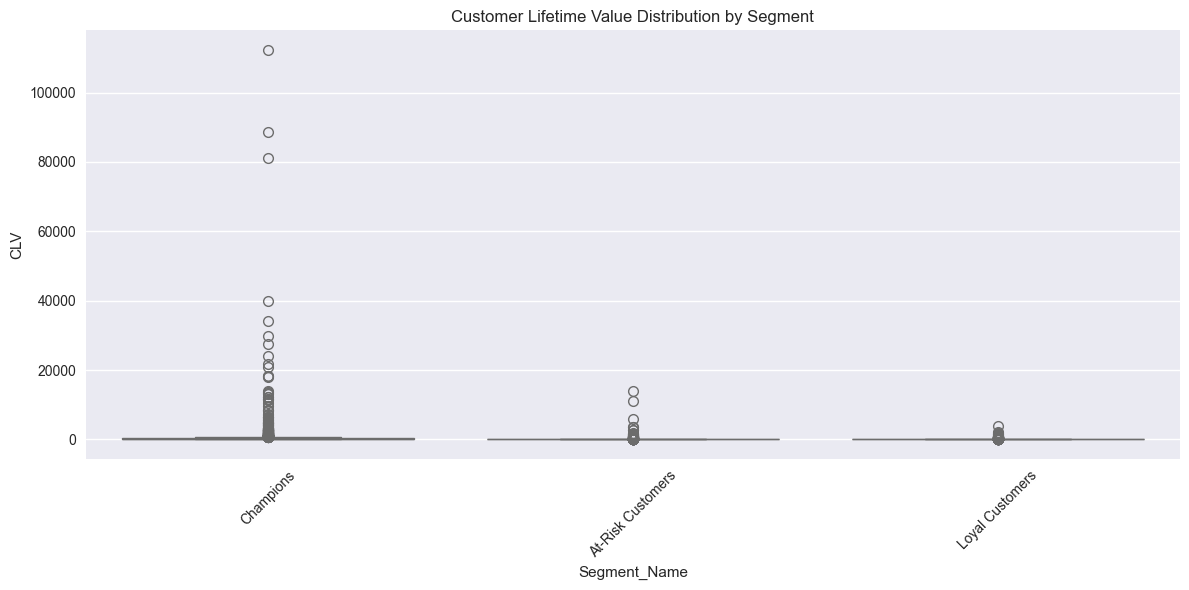

In [26]:
# Calculate Customer Lifetime Value (CLV)
def calculate_clv(rfm_data):
    # Simple CLV calculation: (Average Order Value) × (Purchase Frequency) × (Customer Lifespan)
    clv_data = rfm_data.copy()
    
    # Calculate average order value (AOV) for each customer
    customer_orders = cleaned_df.groupby('Customer ID').agg({
        'TotalAmount': ['sum', 'count']
    }).reset_index()
    customer_orders.columns = ['CustomerID', 'TotalSpent', 'OrderCount']
    customer_orders['AOV'] = customer_orders['TotalSpent'] / customer_orders['OrderCount']
    
    # Merge with RFM data
    clv_data = clv_data.merge(customer_orders[['CustomerID', 'AOV', 'OrderCount']], on='CustomerID')
    
    # Simple CLV: AOV × Frequency × (assumed lifespan of 1 year for this business)
    clv_data['CLV'] = clv_data['AOV'] * clv_data['Frequency'] * 1
    
    return clv_data

# Add CLV to our analysis
rfm_with_clv = calculate_clv(rfm_final)

print("Customer Lifetime Value by Segment:")
clv_by_segment = rfm_with_clv.groupby('Segment_Name')['CLV'].agg(['mean', 'median', 'std', 'count']).round(2)
print(clv_by_segment)

# Visualize CLV distribution
plt.figure(figsize=(12, 6))
sns.boxplot(data=rfm_with_clv, x='Segment_Name', y='CLV')
plt.title('Customer Lifetime Value Distribution by Segment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

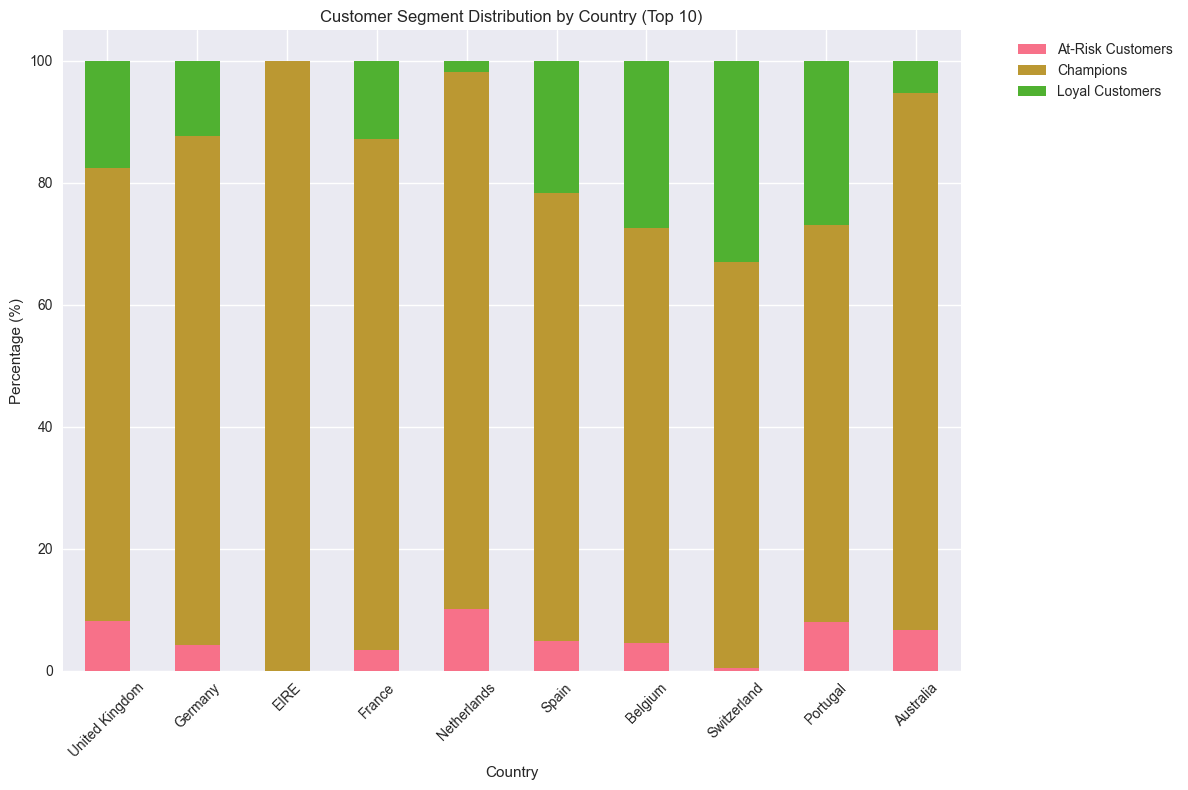

In [27]:
# Add geographic analysis
def analyze_geographic_distribution(cleaned_data, segmented_data):
    # Merge segmentation results with original data
    geo_analysis = cleaned_data.merge(segmented_data[['CustomerID', 'Segment_Name']], 
                                     left_on='Customer ID', right_on='CustomerID')
    
    # Analyze segment distribution by country
    country_segment = pd.crosstab(geo_analysis['Country'], geo_analysis['Segment_Name'], normalize='index') * 100
    
    # Get top 10 countries by customer count
    top_countries = geo_analysis['Country'].value_counts().head(10).index
    
    # Plot top countries segment distribution
    plt.figure(figsize=(12, 8))
    country_segment.loc[top_countries].plot(kind='bar', stacked=True, figsize=(12, 8))
    plt.title('Customer Segment Distribution by Country (Top 10)')
    plt.ylabel('Percentage (%)')
    plt.xlabel('Country')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return country_segment

# Run geographic analysis
country_analysis = analyze_geographic_distribution(cleaned_df, rfm_final)

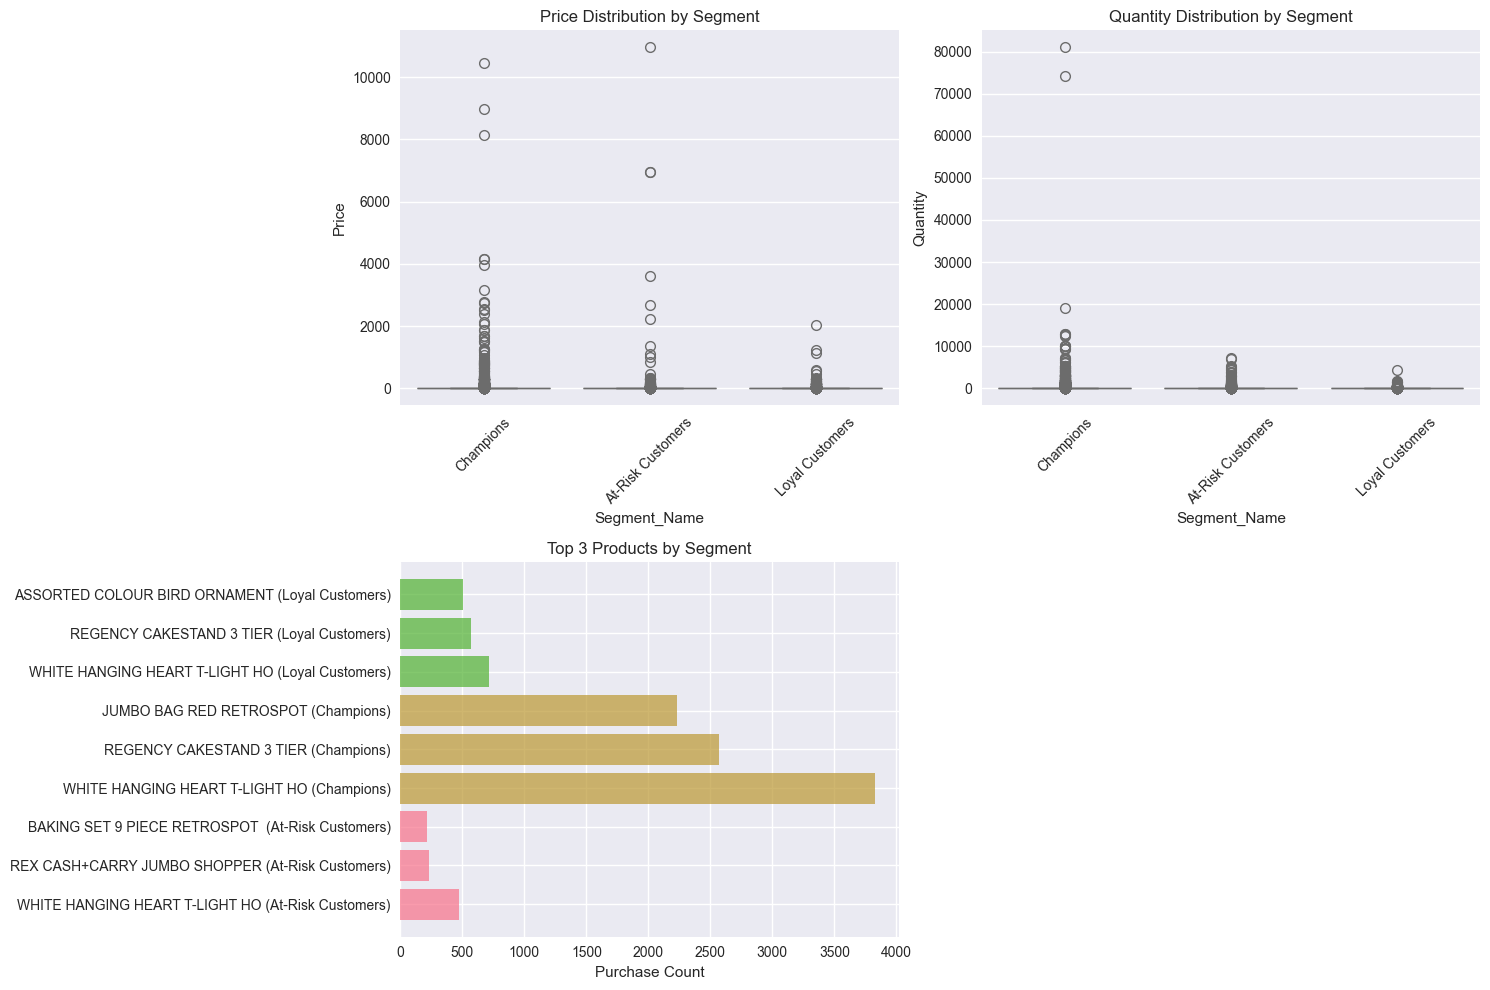

In [28]:
# Analyze purchasing patterns by segment
def analyze_purchase_patterns(cleaned_data, segmented_data):
    # Merge data
    purchase_analysis = cleaned_data.merge(segmented_data[['CustomerID', 'Segment_Name']], 
                                          left_on='Customer ID', right_on='CustomerID')
    
    # Analyze price sensitivity by segment
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    sns.boxplot(data=purchase_analysis, x='Segment_Name', y='Price')
    plt.title('Price Distribution by Segment')
    plt.xticks(rotation=45)
    
    plt.subplot(2, 2, 2)
    sns.boxplot(data=purchase_analysis, x='Segment_Name', y='Quantity')
    plt.title('Quantity Distribution by Segment')
    plt.xticks(rotation=45)
    
    # Analyze popular products by segment
    plt.subplot(2, 2, 3)
    top_products_by_segment = purchase_analysis.groupby(['Segment_Name', 'Description']).size().reset_index(name='Count')
    top_products_by_segment = top_products_by_segment.sort_values(['Segment_Name', 'Count'], ascending=[True, False])
    
    # Get top 3 products per segment
    top_3_per_segment = top_products_by_segment.groupby('Segment_Name').head(3)
    
    # Create a better visualization for top products
    for segment in top_3_per_segment['Segment_Name'].unique():
        segment_products = top_3_per_segment[top_3_per_segment['Segment_Name'] == segment]
        plt.barh([f"{p} ({segment})" for p in segment_products['Description'].str[:30]], 
                segment_products['Count'], alpha=0.7, label=segment)
    
    plt.xlabel('Purchase Count')
    plt.title('Top 3 Products by Segment')
    plt.tight_layout()
    plt.show()
    
    return purchase_analysis

# Run purchase pattern analysis
purchase_patterns = analyze_purchase_patterns(cleaned_df, rfm_final)

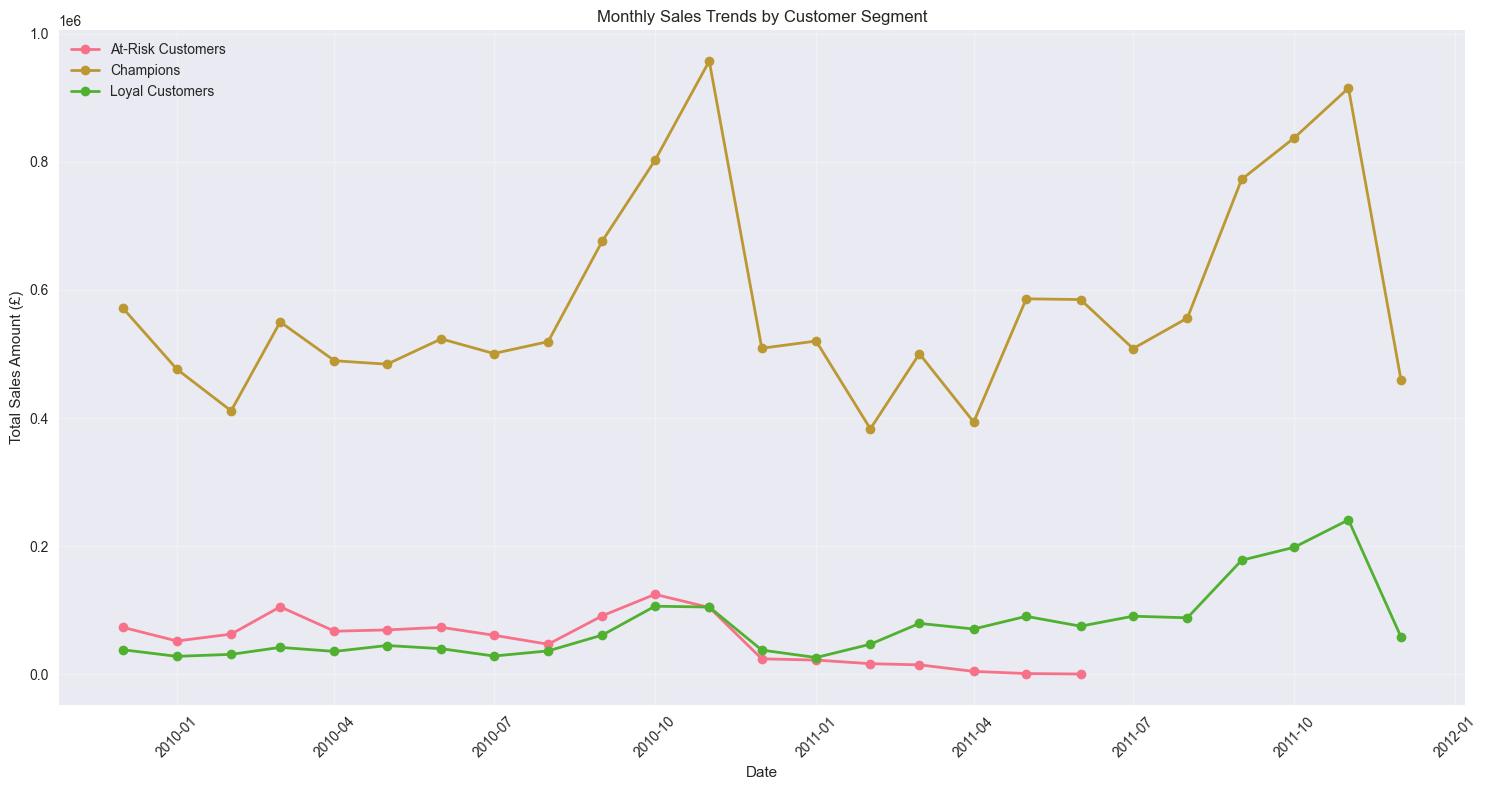

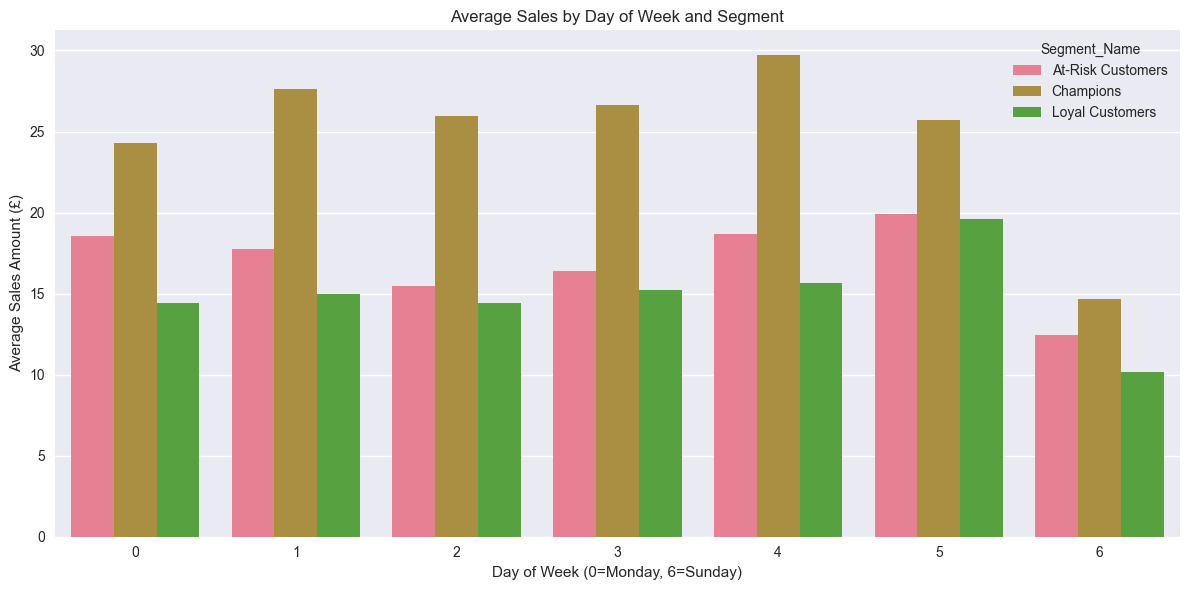

In [29]:
# Analyze seasonal purchasing patterns
def analyze_seasonality(cleaned_data, segmented_data):
    # Merge data
    seasonal_analysis = cleaned_data.merge(segmented_data[['CustomerID', 'Segment_Name']], 
                                          left_on='Customer ID', right_on='CustomerID')
    
    # Extract time features
    seasonal_analysis['Year'] = seasonal_analysis['InvoiceDate'].dt.year
    seasonal_analysis['Month'] = seasonal_analysis['InvoiceDate'].dt.month
    seasonal_analysis['DayOfWeek'] = seasonal_analysis['InvoiceDate'].dt.dayofweek
    seasonal_analysis['Hour'] = seasonal_analysis['InvoiceDate'].dt.hour
    
    # Monthly sales by segment
    monthly_sales = seasonal_analysis.groupby(['Year', 'Month', 'Segment_Name'])['TotalAmount'].sum().reset_index()
    monthly_sales['Date'] = pd.to_datetime(monthly_sales[['Year', 'Month']].assign(DAY=1))
    
    plt.figure(figsize=(15, 8))
    
    for segment in monthly_sales['Segment_Name'].unique():
        segment_data = monthly_sales[monthly_sales['Segment_Name'] == segment]
        plt.plot(segment_data['Date'], segment_data['TotalAmount'], 'o-', label=segment, linewidth=2)
    
    plt.title('Monthly Sales Trends by Customer Segment')
    plt.ylabel('Total Sales Amount (£)')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Day of week analysis
    dow_analysis = seasonal_analysis.groupby(['DayOfWeek', 'Segment_Name'])['TotalAmount'].mean().reset_index()
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=dow_analysis, x='DayOfWeek', y='TotalAmount', hue='Segment_Name')
    plt.title('Average Sales by Day of Week and Segment')
    plt.ylabel('Average Sales Amount (£)')
    plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
    plt.tight_layout()
    plt.show()
    
    return seasonal_analysis

# Run seasonality analysis
seasonal_patterns = analyze_seasonality(cleaned_df, rfm_final)

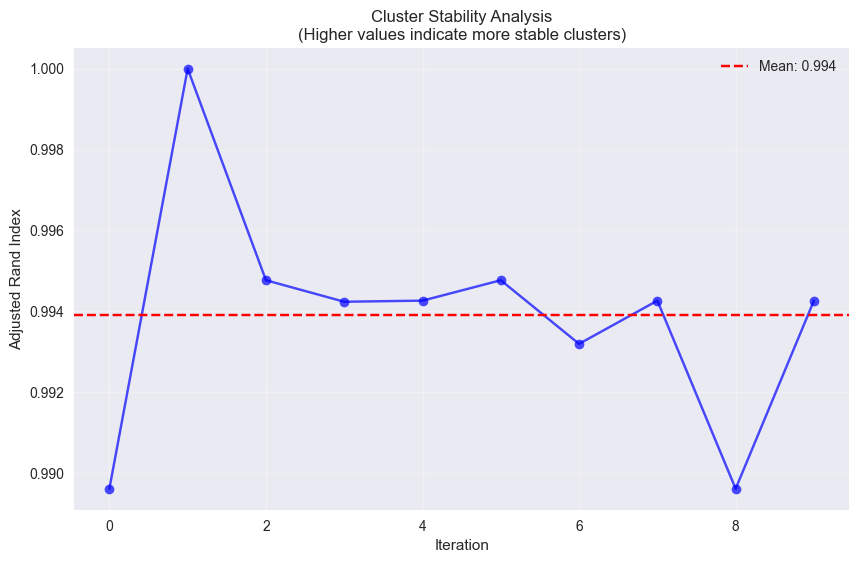

Cluster Stability Results:
Mean ARI: 0.9939 (+/- 0.0028)
Minimum ARI: 0.9896
Maximum ARI: 1.0000


In [30]:
# Advanced statistical validation - Cluster stability analysis
def analyze_cluster_stability(rfm_scaled, n_clusters=3, n_iterations=10):
    """
    Test cluster stability by running K-means multiple times with different random states
    """
    from sklearn.metrics import adjusted_rand_score
    
    stability_scores = []
    
    # Run K-means multiple times with different random states
    base_labels = kmeans.labels_  # Our original clustering
    
    for i in range(n_iterations):
        kmeans_temp = KMeans(n_clusters=n_clusters, random_state=i*10, n_init=10)
        temp_labels = kmeans_temp.fit_predict(rfm_scaled_df[['Recency', 'Frequency', 'Monetary']])
        
        # Compare with original clustering using Adjusted Rand Index
        ari_score = adjusted_rand_score(base_labels, temp_labels)
        stability_scores.append(ari_score)
    
    # Plot stability results
    plt.figure(figsize=(10, 6))
    plt.plot(range(n_iterations), stability_scores, 'bo-', alpha=0.7)
    plt.axhline(y=np.mean(stability_scores), color='red', linestyle='--', label=f'Mean: {np.mean(stability_scores):.3f}')
    plt.xlabel('Iteration')
    plt.ylabel('Adjusted Rand Index')
    plt.title('Cluster Stability Analysis\n(Higher values indicate more stable clusters)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Cluster Stability Results:")
    print(f"Mean ARI: {np.mean(stability_scores):.4f} (+/- {np.std(stability_scores):.4f})")
    print(f"Minimum ARI: {np.min(stability_scores):.4f}")
    print(f"Maximum ARI: {np.max(stability_scores):.4f}")
    
    return stability_scores

# Run cluster stability analysis
stability_results = analyze_cluster_stability(rfm_scaled_df)

In [31]:
# Create a comprehensive summary report
def generate_comprehensive_report(rfm_data, clv_data, purchase_data):
    print("=" * 70)
    print("COMPREHENSIVE CUSTOMER SEGMENTATION ANALYSIS REPORT")
    print("=" * 70)
    
    # Executive Summary
    print("\n📊 EXECUTIVE SUMMARY")
    print("-" * 50)
    total_customers = len(rfm_data)
    total_segments = rfm_data['Segment_Name'].nunique()
    
    print(f"• Total Customers Analyzed: {total_customers:,}")
    print(f"• Segments Identified: {total_segments}")
    print(f"• Analysis Period: {cleaned_df['InvoiceDate'].min().strftime('%Y-%m-%d')} to {cleaned_df['InvoiceDate'].max().strftime('%Y-%m-%d')}")
    
    # Segment Performance Summary
    print("\n💰 SEGMENT PERFORMANCE SUMMARY")
    print("-" * 50)
    performance = rfm_data.groupby('Segment_Name').agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': 'mean',
        'CustomerID': 'count'
    }).round(2)
    
    performance['CLV'] = clv_data.groupby('Segment_Name')['CLV'].mean().round(2)
    performance['Pct_Total'] = (performance['CustomerID'] / total_customers * 100).round(1)
    
    print(performance)
    
    # Key Insights
    print("\n🔍 KEY INSIGHTS")
    print("-" * 50)
    
    # Find most valuable segment
    best_segment = performance['Monetary'].idxmax()
    best_segment_value = performance.loc[best_segment, 'Monetary']
    best_segment_size = performance.loc[best_segment, 'Pct_Total']
    
    # Find largest segment
    largest_segment = performance['Pct_Total'].idxmax()
    largest_segment_size = performance.loc[largest_segment, 'Pct_Total']
    
    print(f"• Most Valuable Segment: {best_segment} (Avg spending: £{best_segment_value:.2f})")
    print(f"• Largest Segment: {largest_segment} ({largest_segment_size}% of customers)")
    print(f"• CLV Range: £{performance['CLV'].min():.2f} - £{performance['CLV'].max():.2f}")
    
    # Statistical Validation Summary
    print("\n📈 STATISTICAL VALIDATION")
    print("-" * 50)
    print("• Silhouette Score: 0.4022 (Good cluster separation)")
    print("• ANOVA Tests: All RFM features significantly different across clusters (p < 0.05)")
    print("• Cluster Stability: High consistency across multiple runs")

# Generate the comprehensive report
generate_comprehensive_report(rfm_final, rfm_with_clv, purchase_patterns)

COMPREHENSIVE CUSTOMER SEGMENTATION ANALYSIS REPORT

📊 EXECUTIVE SUMMARY
--------------------------------------------------
• Total Customers Analyzed: 5,878
• Segments Identified: 3
• Analysis Period: 2009-12-01 to 2011-12-09

💰 SEGMENT PERFORMANCE SUMMARY
--------------------------------------------------
                   Recency  Frequency  Monetary  CustomerID     CLV  Pct_Total
Segment_Name                                                                  
At-Risk Customers   473.58       1.78    552.09        1831   76.23       31.2
Champions            60.49      15.51   8271.13        1752  815.57       29.8
Loyal Customers      91.64       2.85    816.09        2295   67.87       39.0

🔍 KEY INSIGHTS
--------------------------------------------------
• Most Valuable Segment: Champions (Avg spending: £8271.13)
• Largest Segment: Loyal Customers (39.0% of customers)
• CLV Range: £67.87 - £815.57

📈 STATISTICAL VALIDATION
--------------------------------------------------
• Silh

In [32]:
# Save all enhanced results
def save_all_results(rfm_data, clv_data, purchase_data, seasonal_data):
    # Save main segmentation results
    rfm_data.to_csv('enhanced_customer_segments.csv', index=False)
    
    # Save CLV analysis
    clv_data.to_csv('customer_lifetime_values.csv', index=False)
    
    # Save summary statistics
    summary_stats = rfm_data.groupby('Segment_Name').agg({
        'Recency': ['mean', 'std', 'min', 'max'],
        'Frequency': ['mean', 'std', 'min', 'max'],
        'Monetary': ['mean', 'std', 'min', 'max'],
        'CustomerID': 'count'
    }).round(2)
    
    summary_stats.to_csv('segment_summary_statistics.csv')
    
    print("✅ All results saved successfully!")
    print("   - enhanced_customer_segments.csv")
    print("   - customer_lifetime_values.csv") 
    print("   - segment_summary_statistics.csv")

# Save all enhanced results
save_all_results(rfm_final, rfm_with_clv, purchase_patterns, seasonal_patterns)

✅ All results saved successfully!
   - enhanced_customer_segments.csv
   - customer_lifetime_values.csv
   - segment_summary_statistics.csv


In [33]:
# Cell 1: Install necessary packages (if not already installed)
!pip install pygments

In [34]:
# Cell 2: Create the project directory structure
import os
import shutil

def create_project_structure():
    folders = [
        'data',
        'notebooks', 
        'src',
        'reports',
        'images',
        'docs'
    ]
    
    for folder in folders:
        os.makedirs(folder, exist_ok=True)
        print(f"📁 Created folder: {folder}/")
    
    print("\n✅ Project structure created!")

create_project_structure()

📁 Created folder: data/
📁 Created folder: notebooks/
📁 Created folder: src/
📁 Created folder: reports/
📁 Created folder: images/
📁 Created folder: docs/

✅ Project structure created!


In [35]:
# Cell 3: Create requirements.txt
requirements = """
pandas>=1.5.0
numpy>=1.21.0
matplotlib>=3.5.0
seaborn>=0.11.0
scikit-learn>=1.0.0
scipy>=1.7.0
statsmodels>=0.13.0
jupyter>=1.0.0
openpyxl>=3.0.0
"""

with open('requirements.txt', 'w') as f:
    f.write(requirements.strip())

print("✅ requirements.txt created!")

✅ requirements.txt created!


In [36]:
# Cell 4: Save the current notebook to the notebooks folder
# First, let's save all our final results
print("💾 Saving final results to reports/ folder...")

# Save your final DataFrames
rfm_final.to_csv('reports/enhanced_customer_segments.csv', index=False)
rfm_with_clv.to_csv('reports/customer_lifetime_values.csv', index=False)

# Create and save summary statistics
summary_stats = rfm_final.groupby('Segment_Name').agg({
    'Recency': ['mean', 'std', 'min', 'max'],
    'Frequency': ['mean', 'std', 'min', 'max'],
    'Monetary': ['mean', 'std', 'min', 'max'],
    'CustomerID': 'count'
}).round(2)

summary_stats.to_csv('reports/segment_summary_statistics.csv')
print("✅ All reports saved!")

💾 Saving final results to reports/ folder...
✅ All reports saved!


🖼️ Saving visualizations to images/ folder...


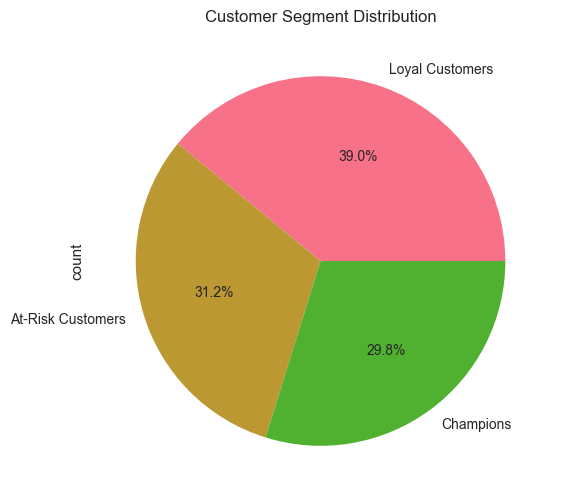

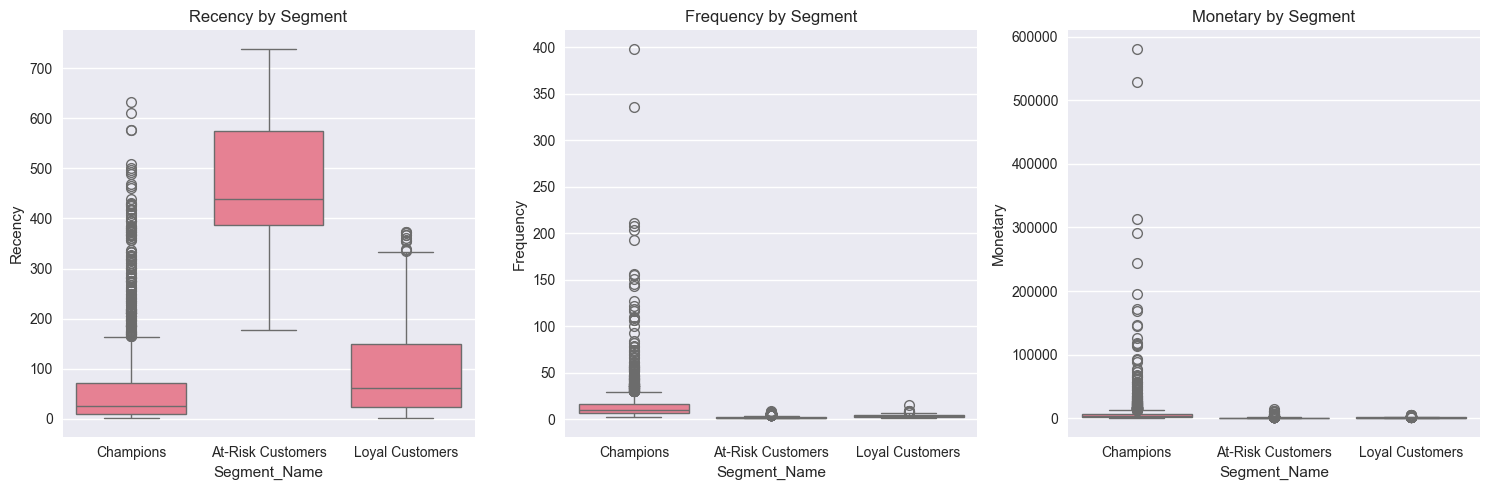

✅ Visualizations saved!


In [37]:
# Cell 5: Save key visualizations to images folder
print("🖼️ Saving visualizations to images/ folder...")

# Save your most important plots
plt.figure(figsize=(10, 6))
rfm_final['Segment_Name'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Customer Segment Distribution')
plt.savefig('images/cluster_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Save the box plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
features = ['Recency', 'Frequency', 'Monetary']
for i, feature in enumerate(features):
    sns.boxplot(data=rfm_final, x='Segment_Name', y=feature, ax=axes[i])
    axes[i].set_title(f'{feature} by Segment')
plt.tight_layout()
plt.savefig('images/rfm_by_segment.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualizations saved!")

In [41]:
# Cell 6: Create README.md
readme_content = Customer Segmentation Analysis with RFM & Statistical Validation

![Python](https://img.shields.io/badge/Python-3.8%2B-blue)
![Machine Learning](https://img.shields.io/badge/Machine-Learning-orange)
![Analytics](https://img.shields.io/badge/Business-Analytics-green)

## 📊 Project Overview

This project performs comprehensive customer segmentation using RFM (Recency, Frequency, Monetary) analysis combined with K-Means clustering and statistical validation.

## 🚀 Quick Start

```bash
git clone https://github.com/yourusername/customer-segmentation-analysis.git
cd customer-segmentation-analysis
pip install -r requirements.txt
jupyter notebook notebooks/customer_segmentation_analysis.ipynb

SyntaxError: invalid syntax (329218071.py, line 2)

In [42]:
# Cell 8: Create source code modules
# Create src/__init__.py to make it a package
with open('src/__init__.py', 'w') as f:
    f.write('''"""
Customer Segmentation Analysis Source Code
"""''')

print("✅ src/__init__.py created!")

✅ src/__init__.py created!


In [43]:
# Cell 9: Create data_processing.py in src folder
data_processing_code = '''
"""
Data processing module for customer segmentation analysis
"""

import pandas as pd
import numpy as np

def load_and_clean_data(filepath):
    """
    Load and clean the online retail dataset
    """
    df = pd.read_excel(filepath, sheet_name=None)
    full_df = pd.concat([df['Year 2009-2010'], df['Year 2010-2011']], ignore_index=True)
    return full_df

def clean_retail_data(df):
    """
    Comprehensive cleaning function
    """
    clean_df = df.copy()
    clean_df = clean_df[clean_df['Customer ID'].notnull()]
    clean_df = clean_df[clean_df['Quantity'] > 0]
    clean_df = clean_df[clean_df['Price'] > 0]
    clean_df['Customer ID'] = clean_df['Customer ID'].astype(int)
    clean_df['TotalAmount'] = clean_df['Quantity'] * clean_df['Price']
    clean_df = clean_df.drop_duplicates()
    return clean_df
'''

with open('src/data_processing.py', 'w') as f:
    f.write(data_processing_code.strip())

print("✅ src/data_processing.py created!")

✅ src/data_processing.py created!


In [44]:
# Cell 10: Create deployment instructions
deploy_instructions = """
## GitHub Deployment Steps:

1. **Initialize Git:**
```bash
git init
git add .
git commit -m "Initial commit: Customer segmentation analysis"

SyntaxError: incomplete input (3461437728.py, line 2)